In [1]:
import ingestor, modeller, fitter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-notebook')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
from cycler import cycler

new_color = cycler(color=["k"])
plt.rcParams['axes.prop_cycle'] = plt.rcParams['axes.prop_cycle'].concat(new_color)

In [4]:
from importlib import reload

reload(fitter)
reload(modeller)
reload(ingestor)

<module 'ingestor' from '/media/dwu402/Data/wrap-mad/ingestor.py'>

In [5]:
context = ingestor.Context("runs/minimal4.3.run")

In [6]:
solver = fitter.Fitter(context)

In [7]:
for rhoi in np.logspace(-6, 8, num=57):
    solver.solve(rhoi)
    solver.problems[0].initial_guess = solver.solutions[str(rhoi)][-1].x

# Validation

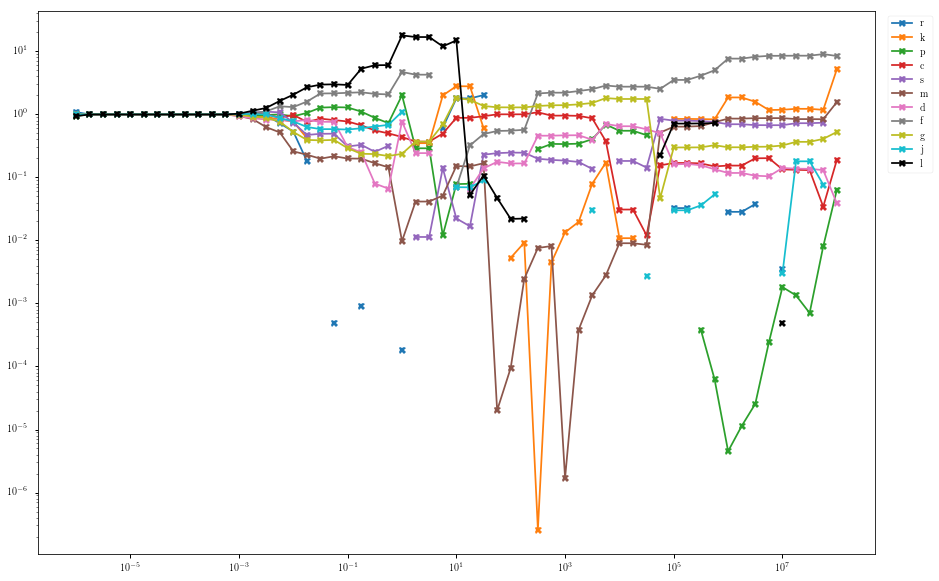

In [8]:
rhos = [float(rho) for rho in solver.solutions.keys()]
vals = [val[0].x for val in solver.solutions.values()]
plt.plot(rhos, vals, 'X-')
plt.legend("rkpcsmdfgjl", loc="best", bbox_to_anchor=(1.01, 1))
plt.xscale("log")
plt.yscale("log", nonposy="mask")

Text(0, 0.5, 'Number')

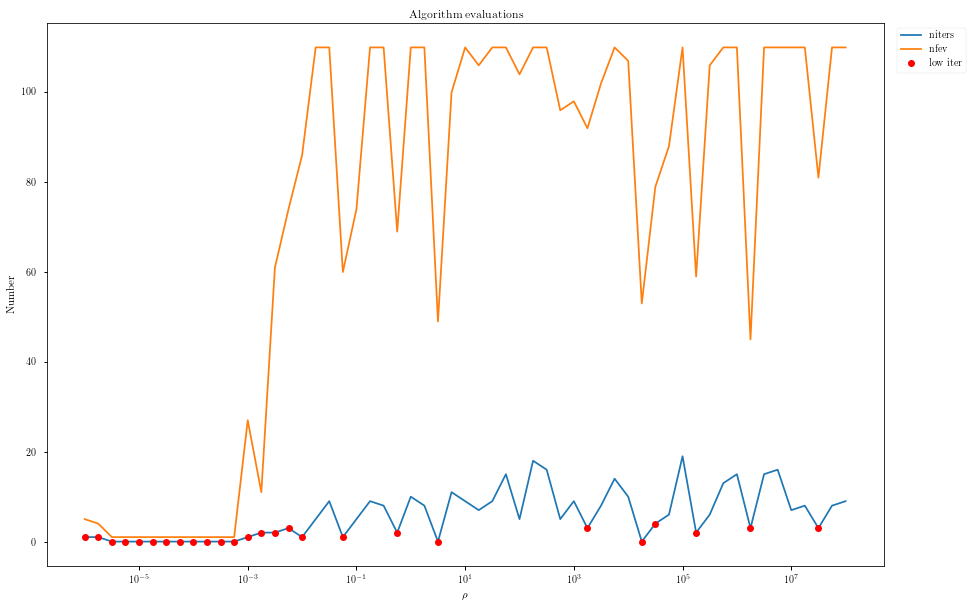

In [9]:
iters_list = np.array([[float(key), value[0].nit] for key, value in solver.solutions.items()])
fevs_list = np.array([[float(key), value[0].nfev] for key, value in solver.solutions.items()])
plt.semilogx(*iters_list.T, *fevs_list.T)

low_iters = np.array([[k,v] for k,v in iters_list if v < 5])
plt.plot(*low_iters.T, 'ro')

plt.legend(["niters", "nfev", "low iter"], 
           loc="best", bbox_to_anchor=(1.01, 1))
plt.title("Algorithm evaluations")
plt.xlabel(r"$\rho$")
plt.ylabel("Number")

In [10]:
def tokey(rho, ps):
    return f"{'y'.join(map(str,ps))}r{rho}"
getx = fitter.ca.Function("getx", [solver.models[0].ts, *solver.models[0].cs], solver.models[0].xs)
    

[ 1.7932575   2.80211884  0.07834327  0.88272713  0.02230993  0.15177332
  0.          0.0694609   1.82626581  0.06995035 14.92973936]
[[ 1.77589387e-04  3.47923979e-02 -6.86637154e-01]]


Text(0.5, 0, 'time, t')

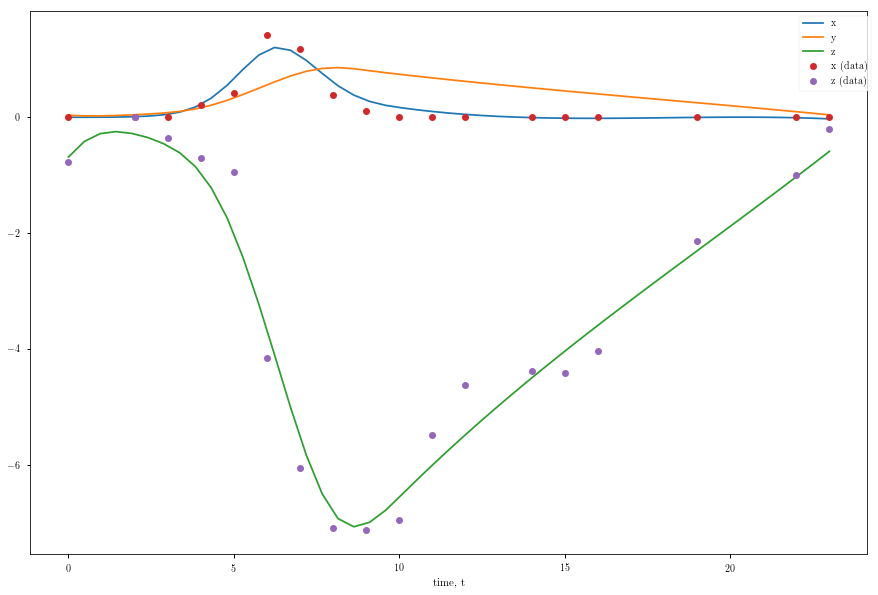

In [39]:
target_rho = 10.0
c_end = solver.problems[0].cache.results[tokey(target_rho, solver.solutions[str(target_rho)][0].x)].x
print(solver.solutions[str(target_rho)][0].x)
xs_end = np.array([np.array(i) for i in getx(solver.models[0].observation_times, 
                                         *fitter.argsplit(c_end, 
                                                          3)
                                        )])
print(xs_end[:,0].T)
plt.plot(solver.models[0].observation_times, np.hstack([xs_end[0], xs_end[1], xs_end[2]]),
         context.datasets[0]['t'], context.datasets[0]['x'], 'o',
         context.datasets[0]['t'], context.datasets[0]['z'], 'o')
plt.legend(list("xyz") + ["x (data)", "z (data)"], loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("time, t")

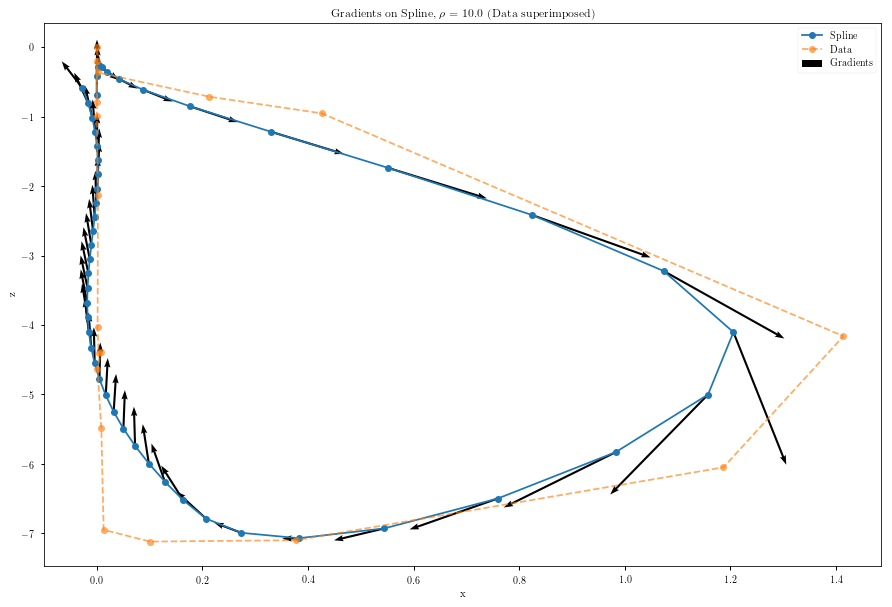

In [40]:
spline_dfield = np.array([context.model(t, xs_end[:,i], solver.solutions[str(target_rho)][0].x) 
                 for i,t in enumerate(solver.models[0].observation_times)])

spline_dfield = spline_dfield.reshape(spline_dfield.shape[:2])

plt.plot(xs_end[0], xs_end[2], 'o-')
plt.plot(context.datasets[0]['x'], context.datasets[0]['z'], 'o--', alpha=0.65)
plt.quiver(xs_end[0], xs_end[2], spline_dfield[:,0], spline_dfield[:,2], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho} (Data superimposed)")
plt.xlabel("x")
plt.ylabel("z")
plt.legend(["Spline", "Data", "Gradients"])

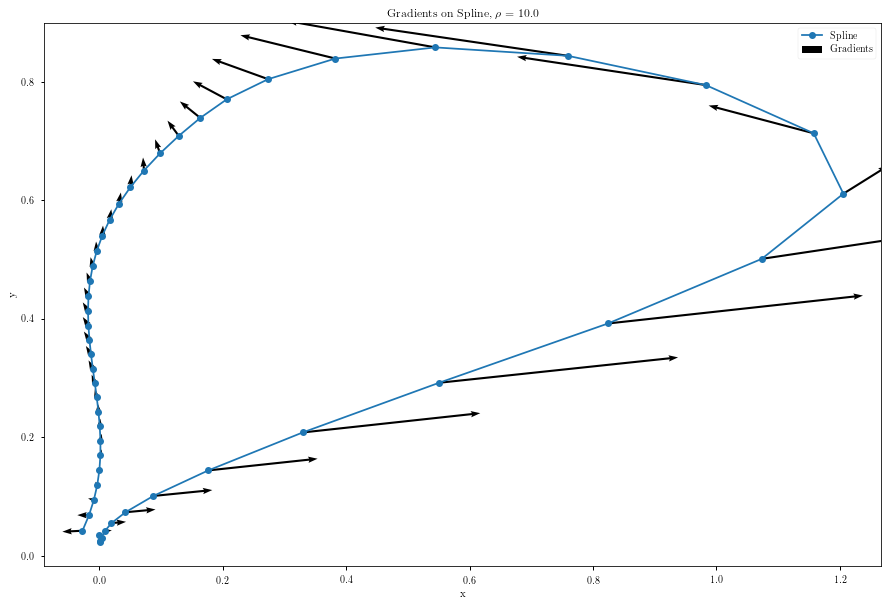

In [41]:
plt.plot(xs_end[0], xs_end[1], 'o-')
plt.quiver(xs_end[0], xs_end[1], spline_dfield[:,0], spline_dfield[:,1], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Spline", "Gradients"])

Text(0.5, 0, '$\\rho$, Model Weighting Parameter')

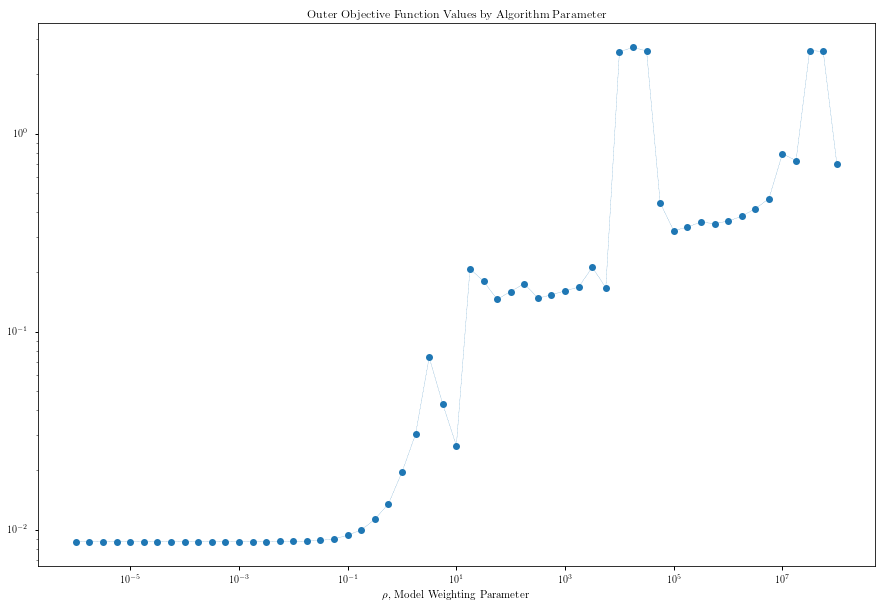

In [14]:
outer_objective_values = np.array([[float(rho), val[0].fun - solver.regularisation(val[0].x)] for rho, val in solver.solutions.items()])
plt.loglog(*outer_objective_values.T, 'o--', linewidth=0.25)
plt.title("Outer Objective Function Values by Algorithm Parameter")
plt.xlabel(r"$\rho$, Model Weighting Parameter")

In [15]:
inner_objective_values = np.array([[r, solver.problems[0].cache.results[tokey(r, v)].fun] for r,v in zip(rhos, vals)])
dfield = np.abs(np.hstack([np.array(rhos).reshape(-1,1), 
                           ((inner_objective_values - outer_objective_values)[:,1] / rhos).reshape(-1,1)]))


In [16]:
dfield_fn = lambda r, v: solver.inner_objectives[0]._obj_fn2(solver.models[0].observation_times,
                                                             *fitter.argsplit(solver.problems[0].cache.results[tokey(r, v)].x, 3),
                                                             *v,
                                                             solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0]),
                                                             len(context.datasets[0]['t']),
                                                             *solver.inner_objectives[0].pad_observations(context.datasets[0]['y']),
                                                             r)

dfield_direct = np.array([[r, dfield_fn(r, v)] for r, v in zip(rhos, vals)])

Text(0.5, 0, '$\\rho$, Model Weighting Parameter')

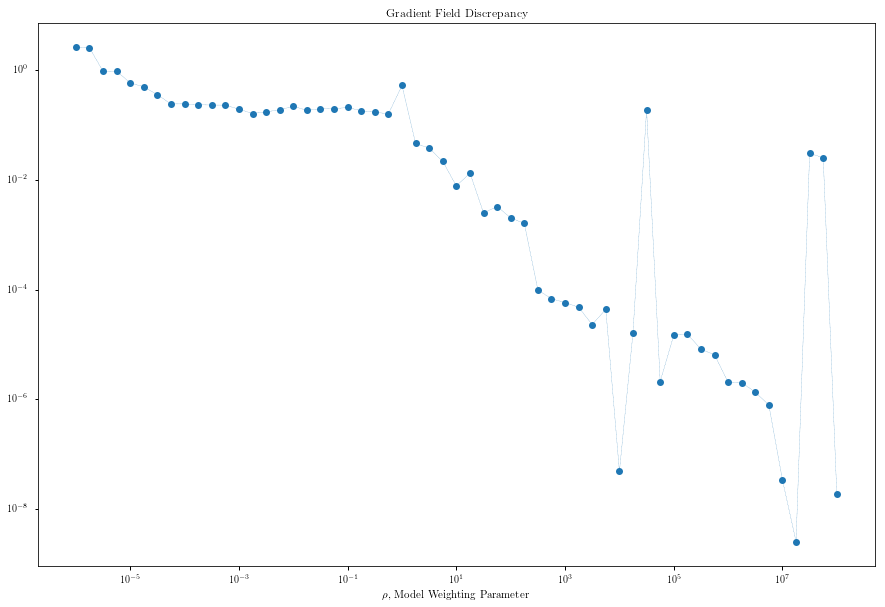

In [17]:
plt.loglog(*dfield_direct.T, 'o--', linewidth=0.25)
plt.title("Gradient Field Discrepancy")
plt.xlabel(r"$\rho$, Model Weighting Parameter")

Text(0, 0.5, 'Diff Field')

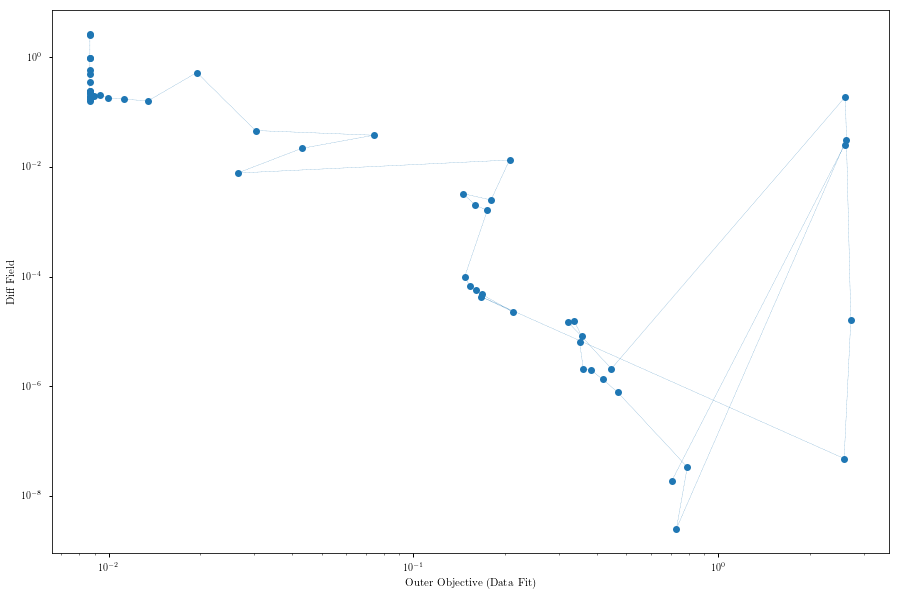

In [18]:
plt.loglog(outer_objective_values[:,1], dfield_direct[:,1], '--o', linewidth=0.25)
plt.xlabel("Outer Objective (Data Fit)")
plt.ylabel("Diff Field")

Text(0, 0.5, '$\\kappa$')

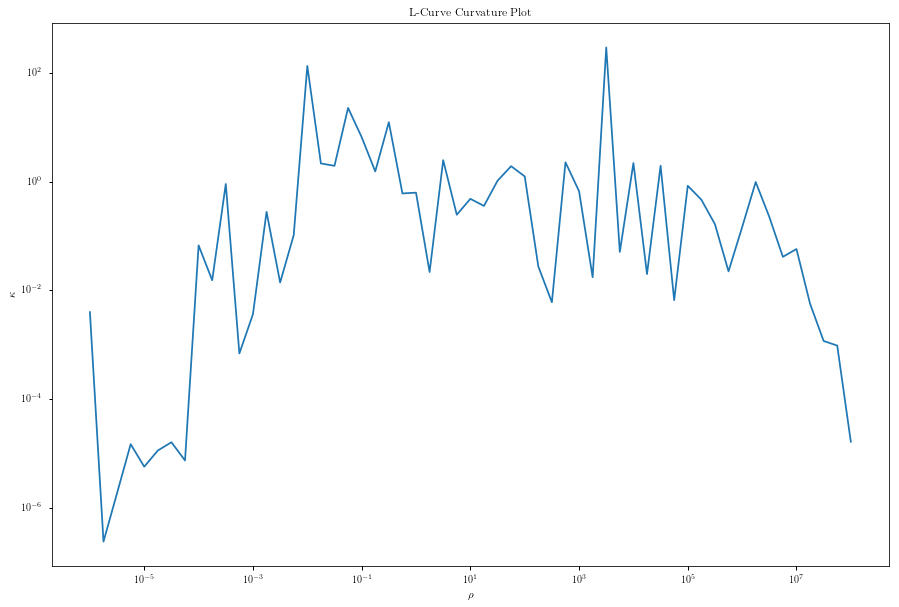

In [19]:
curv_dx = np.gradient(np.log(outer_objective_values[:,1]))
curv_dy = np.gradient(np.log(dfield_direct[:,1]))
curv_dx2 = np.gradient(curv_dx)
curv_dy2 = np.gradient(curv_dy)

kappa = np.abs(curv_dx*curv_dy2 - curv_dy*curv_dx2)/(curv_dx**2 + curv_dy**2)**(3/2)

plt.loglog(rhos, kappa)
plt.title("L-Curve Curvature Plot")
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\kappa$")

## Odd Validation

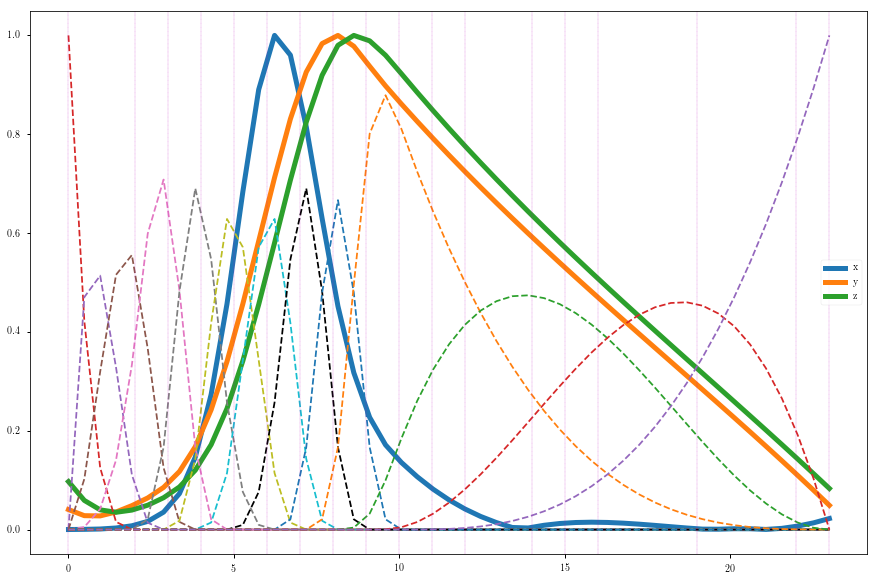

In [42]:
bfn = modeller.ca.Function('basis_fns', [solver.models[0].ts], [solver.models[0].basis])
plt.plot(solver.models[0].observation_times, np.abs(np.hstack([xs_end[0]/max(abs(xs_end[0])), 
                                             xs_end[1]/max(abs(xs_end[1])), 
                                             xs_end[2]/max(abs(xs_end[2]))])),
         linewidth=5)
plt.plot(solver.models[0].observation_times, bfn(solver.models[0].observation_times), '--')
plt.legend('xyz')
[plt.axvline(x=i, color='m', linewidth=0.25, linestyle='--') for i in context.datasets[0]['t']]
print("")

In [21]:
# generate a crude correlation plot

import pandas as pd

results = pd.DataFrame({r"$\rho$": np.log(rhos)})
for idx, name in enumerate("rkpcsmdfgjl"):
    results[name] = [v[idx] for v in vals]
    

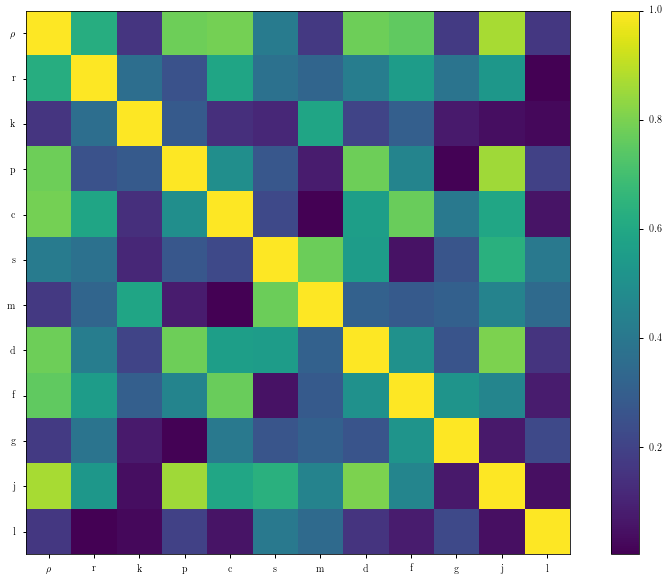

In [22]:
plt.imshow(np.abs(results.corr()))
plt.colorbar()
plt.xticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.yticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.grid(False)

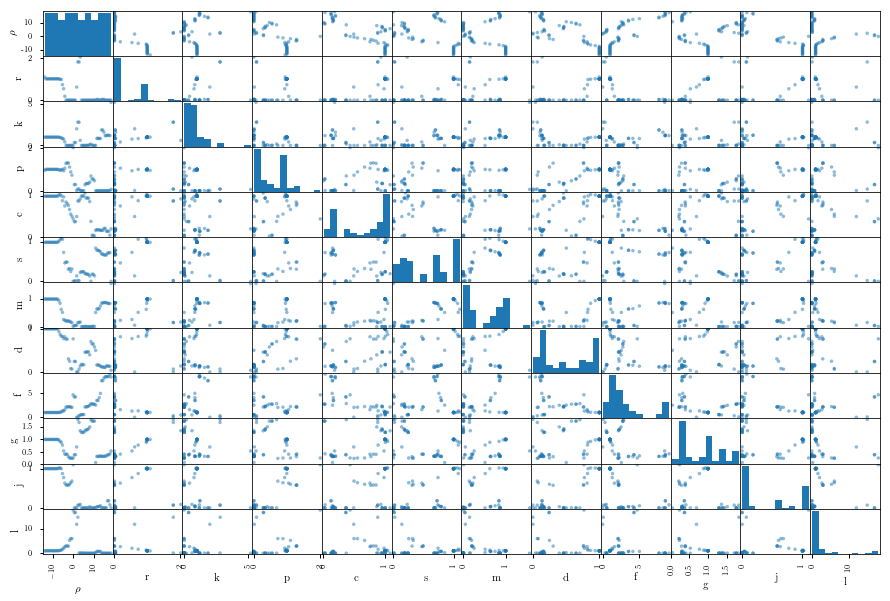

In [23]:
ax = pd.plotting.scatter_matrix(results)
for a in ax.flatten():
    a.grid(False)

## Smoothing Experiments

In [24]:
from scipy import interpolate

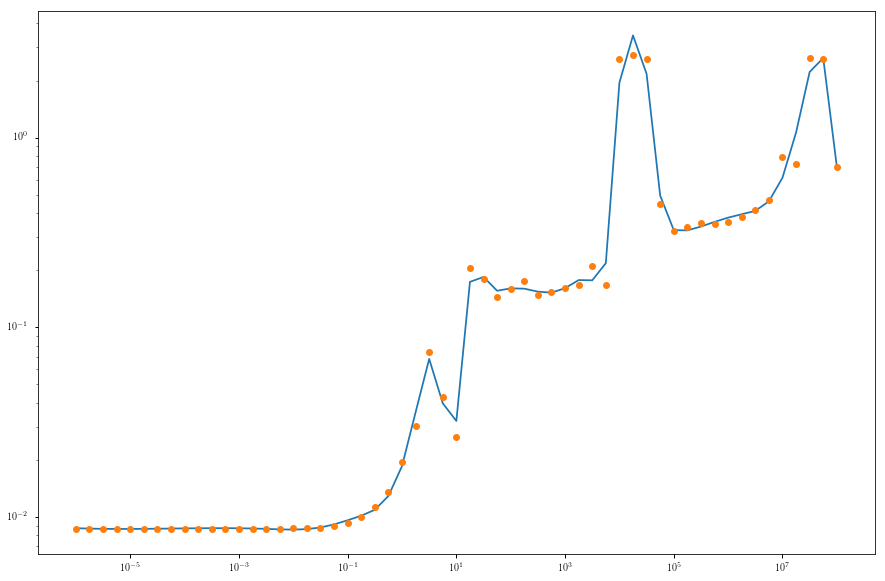

In [25]:
smooth_outer = interpolate.UnivariateSpline(np.log10(rhos), np.log10(outer_objective_values[:,1]), s=0.125)
souter =  np.array([10**x for x in smooth_outer(np.log10(rhos))])
plt.loglog(rhos, souter, rhos, outer_objective_values[:,1], 'o')

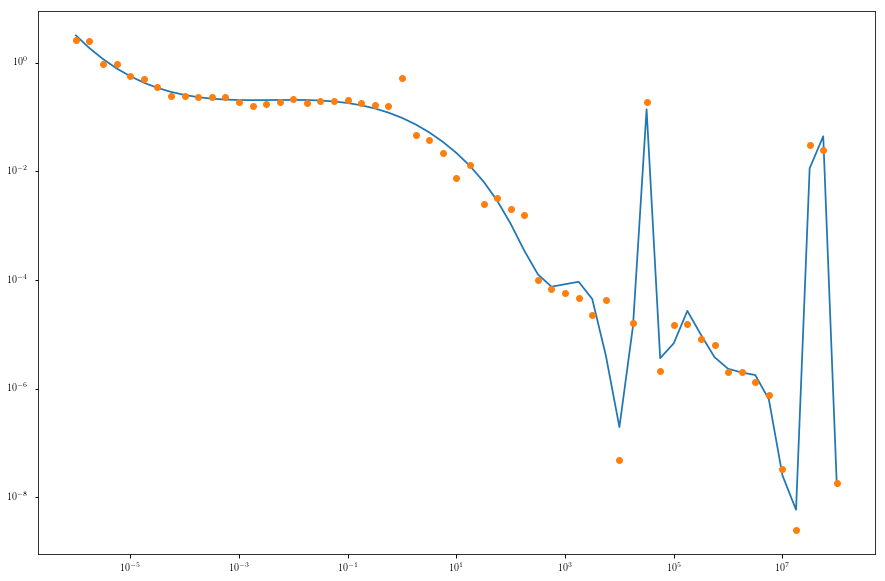

In [26]:
smooth_dfield = interpolate.UnivariateSpline(np.log10(rhos), np.log10(dfield_direct[:,1]), s=4)
sfield =  np.array([10**x for x in smooth_dfield(np.log10(rhos))])
plt.loglog(rhos, sfield, rhos, dfield_direct[:,1], 'o')

In [27]:
rhos_log_finer = np.linspace(np.log10(rhos[0]), np.log10(rhos[-1]), len(rhos)*5)
sx = smooth_outer(rhos_log_finer)
sy = smooth_dfield(rhos_log_finer)
plottable_sx = 10**sx
plottable_sy = 10**sy

Text(0, 0.5, 'Gradient Field Discrepancy')

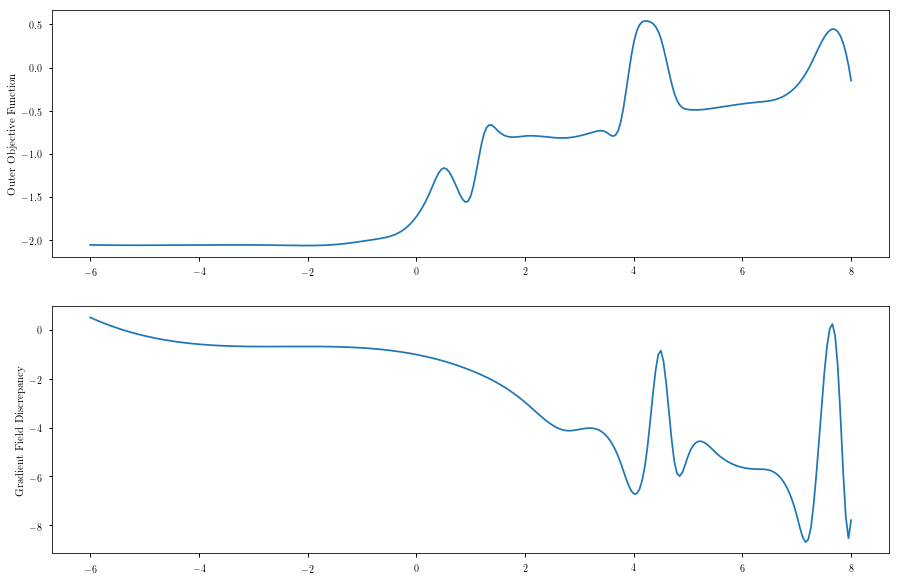

In [28]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(rhos_log_finer, sx)
ax2.plot(rhos_log_finer, sy)
ax1.set_ylabel("Outer Objective Function")
ax2.set_ylabel("Gradient Field Discrepancy")

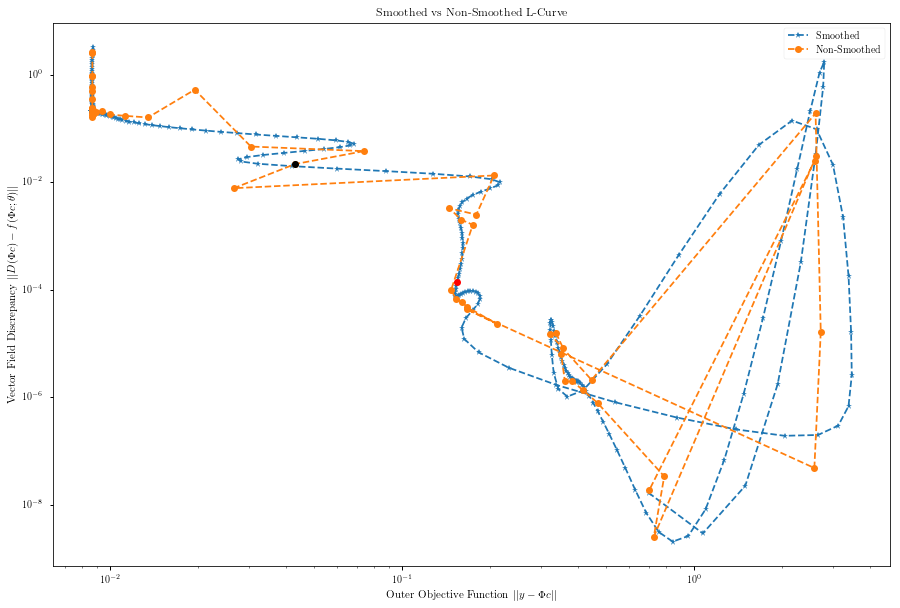

In [29]:
plt.loglog(plottable_sx, plottable_sy, '*--', outer_objective_values[:,1], dfield_direct[:,1], 'o--')
plt.title("Smoothed vs Non-Smoothed L-Curve")
plt.xlabel(r"Outer Objective Function $||y-{\Phi}c||$")
plt.ylabel(r"Vector Field Discrepancy $||D({\Phi}c) - f({\Phi}c; \theta)||$")
plt.legend(["Smoothed", "Non-Smoothed"])

plt.loglog(plottable_sx[np.argmin(np.abs(rhos_log_finer - 2.5))],
           plottable_sy[np.argmin(np.abs(rhos_log_finer - 2.5))],
           'ro',
           outer_objective_values[np.argmin(np.abs(np.array(rhos) - 5)), 1],
           dfield_direct[np.argmin(np.abs(np.array(rhos) - 5)), 1], 
           'ko')

Text(0, 0.5, '$\\kappa$')

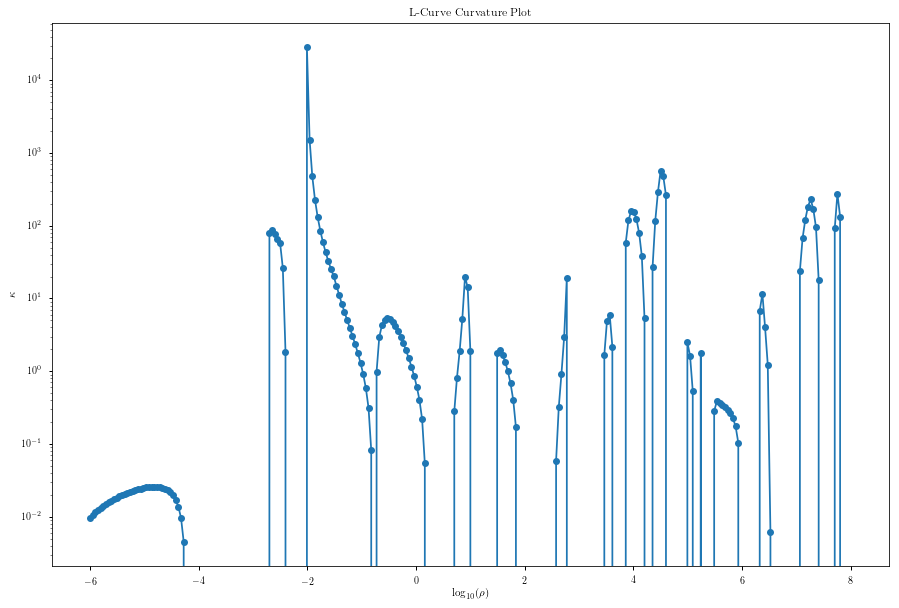

In [30]:
# ? curvature
f_dx = smooth_outer.derivative(1)
f_dy = smooth_dfield.derivative(1)
f_dx2 = smooth_outer.derivative(2)
f_dy2 = smooth_dfield.derivative(2)

scurv_dx = f_dx(rhos_log_finer)
scurv_dy = f_dy(rhos_log_finer)
scurv_dx2 = f_dx2(rhos_log_finer)
scurv_dy2 = f_dy2(rhos_log_finer)

kappa_fine = scurv_dx*scurv_dy2 - scurv_dy*scurv_dx2/(scurv_dx**2 + scurv_dy**2)**(3/2)

plt.semilogy(rhos_log_finer, kappa_fine, 'o-')
plt.title("L-Curve Curvature Plot")
plt.xlabel(r"$\log_{10}(\rho)$")
plt.ylabel(r"$\kappa$")

Text(0, 0.5, '$\\kappa$')

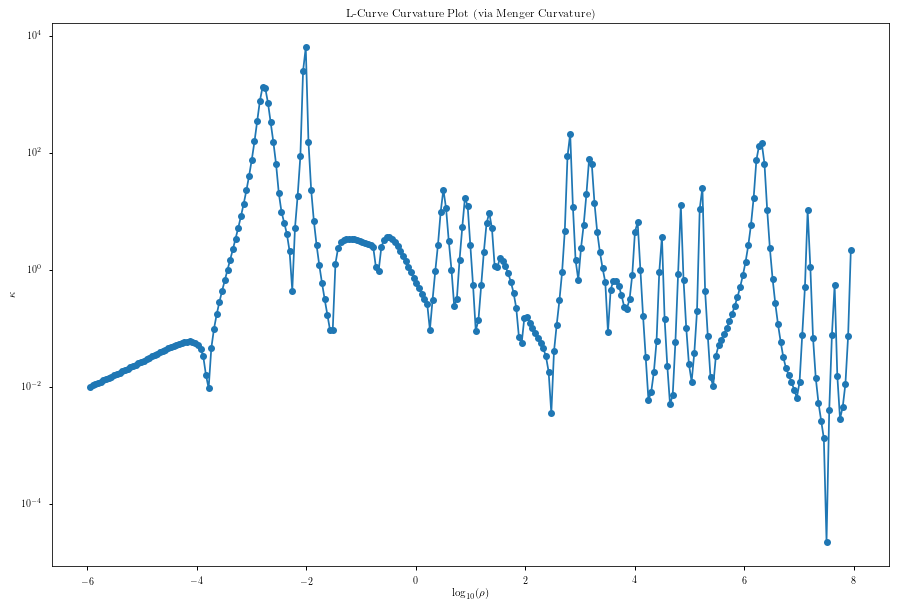

In [31]:
# menger curvature
curvs = []

for idx in range(1, len(rhos_log_finer)-1):
    xs = sx[idx-1:idx+2]
    ys = sy[idx-1:idx+2]
    ps = np.vstack([xs,ys]).T
    curvs.append(2*np.abs(np.cross(ps[1] - ps[0], ps[2]-ps[1]))/(
            np.linalg.norm(ps[0]-ps[1])*np.linalg.norm(ps[1]-ps[2])*np.linalg.norm(ps[2]-ps[0])))

plt.semilogy(rhos_log_finer[1:-1], np.array(curvs), 'o-')
plt.title("L-Curve Curvature Plot (via Menger Curvature)")
plt.xlabel(r"$\log_{10}(\rho)$")
plt.ylabel(r"$\kappa$")

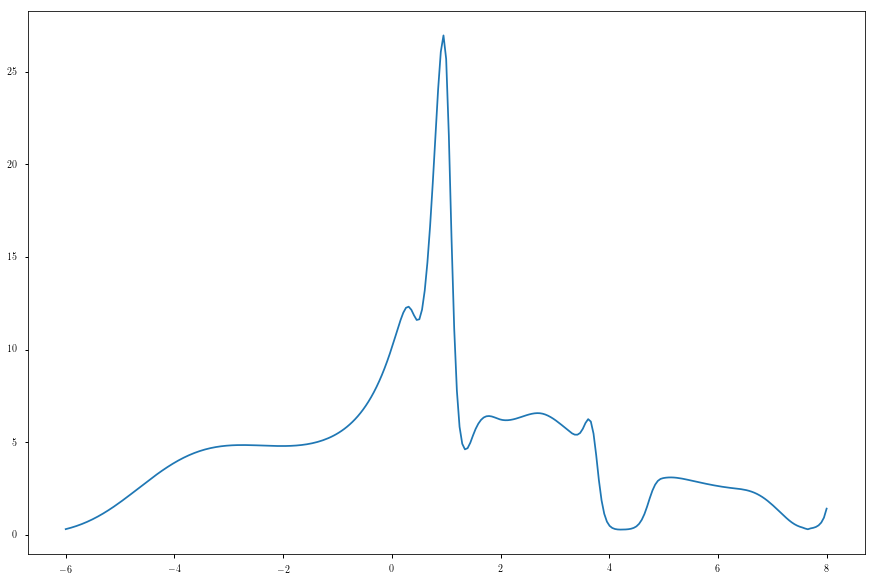

In [32]:
# implement the heuristic measurement
origin  = (0,0)
xy = np.array(list(zip(plottable_sx, plottable_sy)))
distances = [1/np.linalg.norm(xyi) for xyi in xy]
plt.plot(rhos_log_finer, distances)

0.07449116856206009 : 0.07309975027548324
0.2827284706221611 : 0.2322439702815178


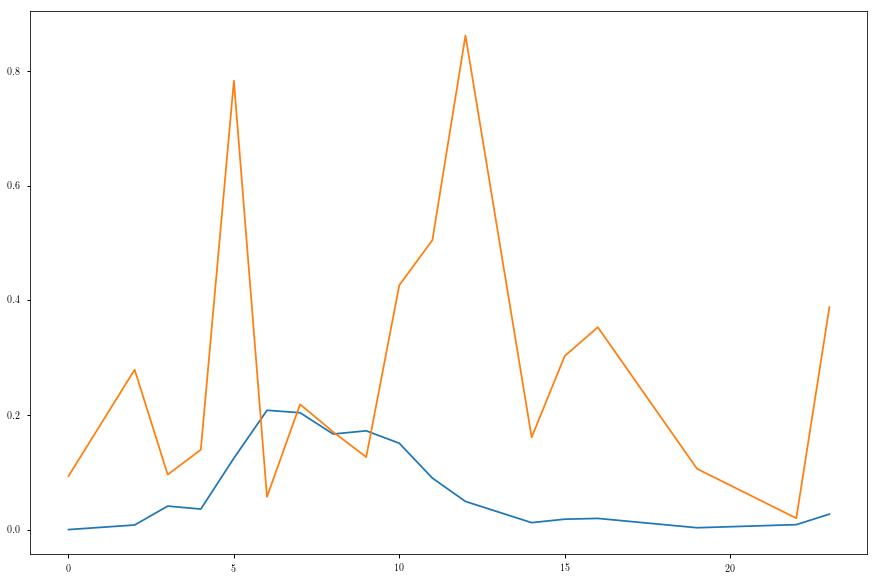

In [45]:
observable_x = solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0])@xs_end[0]
observable_z = solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0])@xs_end[2]

x_err = np.abs(observable_x.T - np.array(context.datasets[0]['x'])).reshape(-1,)
z_err = np.abs(observable_z.T - np.array(context.datasets[0]['z'])).reshape(-1,)

t = np.array(context.datasets[0]['t'])

plt.plot(t, x_err, t, z_err)
print(f"{np.mean(x_err)} : {np.std(x_err)}")
print(f"{np.mean(z_err)} : {np.std(z_err)}")


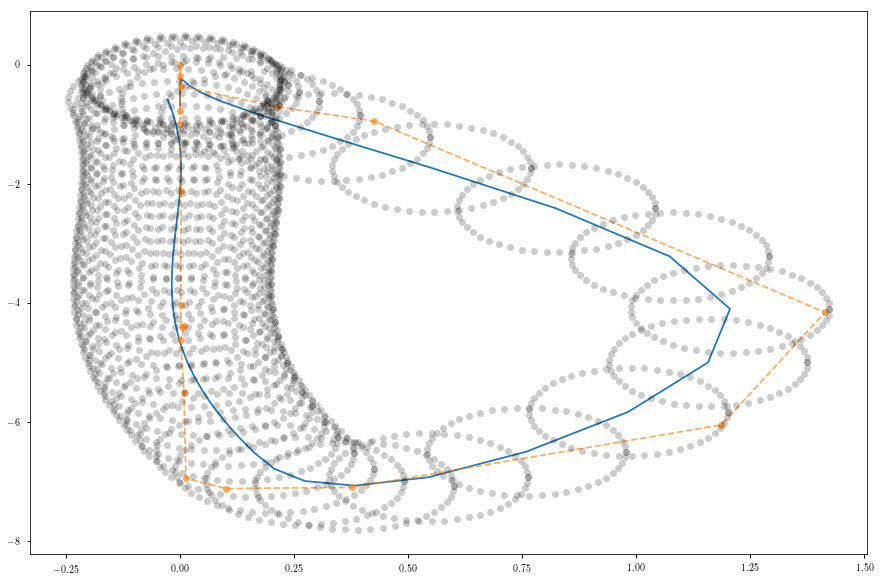

In [46]:
x0, y0 = xs_end[[0,2], :]
xscale = np.mean(x_err) + 1.96*np.std(x_err)
zscale = np.mean(z_err) + 1.96*np.std(z_err)
circle_x, circle_y = [x0 + xscale*np.cos(np.linspace(0, 2*np.pi, 50)), y0 + zscale*np.sin(np.linspace(0, 2*np.pi, 50))]

plt.plot(xs_end[0], xs_end[2])
plt.plot(context.datasets[0]['x'], context.datasets[0]['z'], 'o--', alpha=0.65)
plt.plot(circle_x, circle_y, 'ko', alpha=0.2)
print('')


In [35]:
## Use heuristic to estimate the "ideal" parameter
maximus = 10**rhos_log_finer[np.argmax(distances)+1]
print(f"{maximus}\n is the spike")
closest_rho = rhos[np.argmin(np.abs(rhos-maximus))]
print(f"{closest_rho}\n is the closest")

9.999999999999979
 is the spike
10.0
 is the closest


## Analysis

[0. 0. 0.]
[-3.32401071 -0.23441777]
[-0. -0. -0.]
[-5.2317448 -5.3530359]
['z-saddle', 'z-saddle', 'z-saddle']
['z-unstable', 'z-saddle']


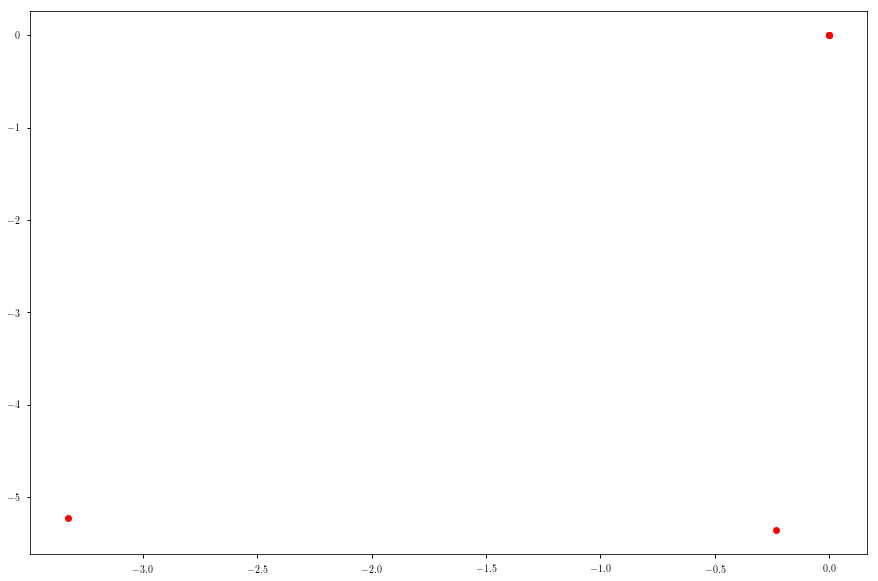

In [43]:
r,k,p,m,s,c,d,f,g,j,l = solver.solutions[str(target_rho)][0].x
characteristic1 = np.roots([-d, s, 0, -d*c*c*c, 0])
temp_alpha = (s*r*r*r)/(c*c*c*k*k*k+r*r*r) - d*r/k
characteristic2 = np.roots([temp_alpha, p, m*m*temp_alpha])

# these are the values of gamma and xi
print(characteristic1)
print(characteristic2)

eq_values1 = l*characteristic1/(f*characteristic1 - g)
eq_values2 = (j*k*characteristic2 + l*r)/(f*r-g*k)

print(eq_values1)
print(eq_values2)

rk = r/k

def is_stable(point):
    x,y,z = point
    G = f*y-g
    A = r-k*y
    B = -k*x
    C = p/(m**2+x**2) - (2*p*x**2)/(m**2+x**2)**2
    D = (3*s*y**2)/(c**3 + y**3) - d - (3*s*y**5)/(c**3 + y**3)**2
    character = (G<0, (A+D)<0 , A*D-B*C>0)
    if all(character):
        return "z-xy"
    elif character[0:3:2] == (True, False):
        return "z-saddle"
    elif character == (False, True, True):
        return "unstable-xy"
    elif character[0]:
        return "z-unstable"
    else:
        return "unstable-unstable"
    
stabilities1 = [is_stable([0, ch, eq]) for ch, eq in zip(characteristic1, eq_values1)]
stabilities2 = [is_stable([ch, rk, eq]) for ch, eq in zip(characteristic2, eq_values2)]

print(stabilities1)
print(stabilities2)

plt.plot([0]*len(eq_values1[np.isreal(eq_values1)]), eq_values1[np.isreal(eq_values1)], 'ro')
plt.plot(characteristic2[np.isreal(eq_values2)], eq_values2[np.isreal(eq_values2)], 'ro')

In [37]:
solver.solutions

{'1e-06': [     fun: 0.008688387673065762
       jac: array([ 5.60726867e-07, -1.53557337e-09, -3.33867606e-07, -1.93068814e-09,
         -2.31128644e-08,  1.51128464e-09, -2.35030089e-09,  1.21777848e-08,
         -2.12839226e-09, -3.03465085e-09, -3.87118190e-07])
   message: 'Local minimum reached (|pg| ~= 0)'
      nfev: 5
       nit: 1
    status: 0
   success: True
         x: array([1.08889467, 0.99963858, 0.94698979, 1.00008258, 0.99645983,
         0.99999074, 0.99958421, 1.00054601, 1.00039567, 1.00044383,
         0.93698261])],
 '1.778279410038923e-06': [     fun: 0.008688341219780718
       jac: array([ 4.36418288e-11,  8.89298920e-12,  2.88700488e-10,  1.55732117e-11,
          1.19967145e-10, -1.51656978e-11,  1.21193164e-11, -5.21296792e-11,
         -1.62982384e-11,  1.13275709e-11, -2.34781858e-10])
   message: 'Local minimum reached (|pg| ~= 0)'
      nfev: 4
       nit: 1
    status: 0
   success: True
         x: array([1.00022246, 0.99989041, 0.99983111, 1.0003991

In [38]:
rhos

[1e-06,
 1.778279410038923e-06,
 3.162277660168379e-06,
 5.623413251903491e-06,
 1e-05,
 1.778279410038923e-05,
 3.1622776601683795e-05,
 5.623413251903491e-05,
 0.0001,
 0.00017782794100389227,
 0.00031622776601683794,
 0.0005623413251903491,
 0.001,
 0.0017782794100389228,
 0.0031622776601683794,
 0.005623413251903491,
 0.01,
 0.01778279410038923,
 0.03162277660168379,
 0.05623413251903491,
 0.1,
 0.1778279410038923,
 0.31622776601683794,
 0.5623413251903491,
 1.0,
 1.7782794100389228,
 3.1622776601683795,
 5.623413251903491,
 10.0,
 17.78279410038923,
 31.622776601683793,
 56.23413251903491,
 100.0,
 177.82794100389228,
 316.22776601683796,
 562.341325190349,
 1000.0,
 1778.2794100389228,
 3162.2776601683795,
 5623.413251903491,
 10000.0,
 17782.794100389227,
 31622.776601683792,
 56234.13251903491,
 100000.0,
 177827.94100389228,
 316227.7660168379,
 562341.3251903491,
 1000000.0,
 1778279.410038923,
 3162277.6601683795,
 5623413.251903491,
 10000000.0,
 17782794.100389227,
 316227